In [1]:
import os
import copy
import random
import argparse
import time
import numpy as np
from PIL import Image
import scipy.io as scio
import scipy.misc
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
from torch.backends import cudnn
import matplotlib.pyplot as plt

from data_controller import SegDataset
from loss import Loss
from segnet import SegNet as segnet
import sys
sys.path.append("..")
from lib.utils import setup_logger

In [3]:
#os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [4]:
#os.environ["PATH"] = "/usr/local/cuda-10.2/bin:$PATH"

To eval the image three things has to be adjusted:
* path_to_ycb, from where the images are loaded
* path_to_save_results, where result masks are loaded
* index_val_data, the file is in DenseFusion Repository, contains only one image (either paste more entries or change to test_data_list.txt)
* dataset = SegDataset(path_to_ycb, index_val_data, True, 3) 3-> 3* length eval set

In [2]:
# !!!! Use Cuda only if available
use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
path_to_ycb = '/media/angelie/AK Elements/YCB_Video_Dataset/YCB_Video_Dataset'

In [4]:
results_dir = '/media/angelie/AK Elements/YCB_Video_Dataset/YCB_Video_Dataset/vanillaseg_preds_d'
os.makedirs(results_dir, exist_ok=True)

In [5]:
index_val_data = '../datasets/ycb/dataset_config/test_data_list.txt'

In [6]:
depth = np.array(Image.open(os.path.join(path_to_ycb, 'data', '0057/000001-depth.png')))
color = np.array(Image.open(os.path.join(path_to_ycb, 'data', '0057/000001-color.png')))

In [7]:
label = np.array(Image.open(os.path.join(path_to_ycb, 'data', '0057/000001-label.png')))
pred = np.load("/media/angelie/AK Elements/YCB_Video_Dataset/YCB_Video_Dataset/vanillaseg_preds/0057/000001-pred.npy")

## Remove already used test frames from list

In [26]:
val_txt = os.path.abspath('/media/angelie/AK Elements/YCB_Video_Dataset/YCB_Video_Dataset/image_sets/val.txt')
with open(val_txt, 'r') as f:
    val_list = f.read().split('\n')
val_list = ['data/' + name for name in val_list]
print(val_list[:5])
with open(index_val_data, 'r') as f:
    used_val = f.read().split('\n')
print(used_val[:5])

['data/0048/000001', 'data/0048/000002', 'data/0048/000003', 'data/0048/000004', 'data/0048/000005']
['data/0048/000036', 'data/0048/000047', 'data/0048/000083', 'data/0048/000112', 'data/0048/000135']


In [27]:
unused_val = [frame for frame in val_list if frame not in used_val]
unused_val[:50]

['data/0048/000001',
 'data/0048/000002',
 'data/0048/000003',
 'data/0048/000004',
 'data/0048/000005',
 'data/0048/000006',
 'data/0048/000007',
 'data/0048/000008',
 'data/0048/000009',
 'data/0048/000010',
 'data/0048/000011',
 'data/0048/000012',
 'data/0048/000013',
 'data/0048/000014',
 'data/0048/000015',
 'data/0048/000016',
 'data/0048/000017',
 'data/0048/000018',
 'data/0048/000019',
 'data/0048/000020',
 'data/0048/000021',
 'data/0048/000022',
 'data/0048/000023',
 'data/0048/000024',
 'data/0048/000025',
 'data/0048/000026',
 'data/0048/000027',
 'data/0048/000028',
 'data/0048/000029',
 'data/0048/000030',
 'data/0048/000031',
 'data/0048/000032',
 'data/0048/000033',
 'data/0048/000034',
 'data/0048/000035',
 'data/0048/000037',
 'data/0048/000038',
 'data/0048/000039',
 'data/0048/000040',
 'data/0048/000041',
 'data/0048/000042',
 'data/0048/000043',
 'data/0048/000044',
 'data/0048/000045',
 'data/0048/000046',
 'data/0048/000048',
 'data/0048/000049',
 'data/0048/0

In [29]:
new_val_txt = os.path.abspath('../datasets/ycb/dataset_config/holdout_data_list.txt')

with open(new_val_txt, 'w') as f:
    for item in unused_val:
        f.write("%s\n" % item)

# Exploration

In [ ]:
color.shape

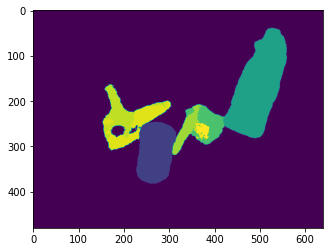

In [14]:
plt.imshow(pred)

In [20]:
np.unique(label)

array([ 0,  4, 12, 18, 20, 21], dtype=uint8)

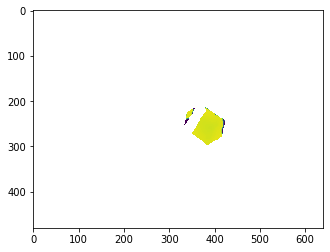

In [24]:
mask = label != 21
depth = np.ma.masked_array(depth, mask)
plt.imshow(depth)

In [ ]:
#!pip install open3d
#import open3d as o3d

In [29]:
#o3d.geometry.PointCloud.create_from_depth_image(np.dstack((color, depth)))


TypeError: create_from_depth_image(): incompatible function arguments. The following argument types are supported:
    1. (depth: open3d::geometry::Image, intrinsic: open3d.open3d_pybind.camera.PinholeCameraIntrinsic, extrinsic: numpy.ndarray[float64[4, 4]] = array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), depth_scale: float = 1000.0, depth_trunc: float = 1000.0, stride: int = 1, project_valid_depth_only: bool = True) -> open3d.open3d_pybind.geometry.PointCloud

Invoked with: masked_array(
  data=[[[  188,   142,   116, 13780],
         [  191,   145,   120, 13810],
         [  200,   150,   151, 13830],
         ...,
         [   29,     4,     4, 15590],
         [   32,    14,    29, 15590],
         [   32,    14,    29, 15550]],

        [[  201,   143,   137, 13770],
         [  196,   138,   133, 13800],
         [  205,   142,   120, 13820],
         ...,
         [   22,     0,     0, 15590],
         [   33,     9,    17, 15590],
         [   36,    12,    20, 15570]],

        [[  192,   116,    51, 13770],
         [  213,   137,    72, 13780],
         [  218,   142,   145, 13790],
         ...,
         [   32,    10,     8, 15590],
         [   46,     8,    34, 15590],
         [   47,     9,    35, 15580]],

        ...,

        [[  111,    62,    40,  8160],
         [  104,    55,    33,  8160],
         [  113,    72,    88,  8160],
         ...,
         [    0,     0,     0,     0],
         [    0,     0,     0,     0],
         [    0,     0,     0,     0]],

        [[  134,    89,    98,  8140],
         [  115,    71,    79,  8140],
         [  111,    70,    84,  8150],
         ...,
         [    0,     0,     0,     0],
         [    0,     0,     0,     0],
         [    0,     0,     0,     0]],

        [[  124,    88,   111,  8140],
         [  117,    81,   104,  8140],
         [  109,    72,    87,  8130],
         ...,
         [    0,     0,     0,     0],
         [    0,     0,     0,     0],
         [    0,     0,     0,     0]]],
  mask=False,
  fill_value=999999,
  dtype=int32)

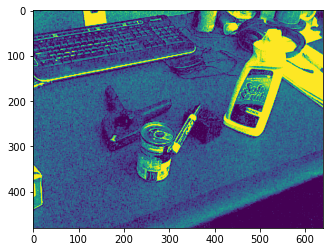

In [26]:
plt.imshow(rgbd[:, :, 2])

In [6]:
num_classes = 22

In [7]:
classes = ["000_background",
           "002_master_chef_can",
           "003_cracker_box",
           "004_sugar_box",
           "005_tomato_soup_can",
           "006_mustard_bottle",
           "007_tuna_fish_can",
           "008_pudding_box",
           "009_gelatin_box",
           "010_potted_meat_can",
           "011_banana",
           "019_pitcher_base",
           "021_bleach_cleanser",
           "024_bowl",
           "025_mug",
           "035_power_drill",
           "036_wood_block",
           "037_scissors",
           "040_large_marker",
           "051_large_clamp",
           "052_extra_large_clamp",
           "061_foam_brick"]

In [10]:
model = segnet()

In [11]:
dev = "cuda" if use_cuda else "cpu"
device = torch.device(dev)
model = model.to(device)

In [12]:
model.load_state_dict(torch.load("trained_models/model_95_0.11404174851998687.pth", map_location=dev))

<All keys matched successfully>

In [13]:
dataset = SegDataset(path_to_ycb, index_val_data, False, 2948) 

In [14]:
dataset.data_len

2948

In [15]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=int(10))

In [16]:
model.eval()

SegNet(
  (conv11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn21): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn22): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn31): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn32): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, 

In [17]:
criterion = Loss()

In [18]:
palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128]

zero_pad = 256 * 3 - len(palette)
for i in range(zero_pad):
    palette.append(0)

In [19]:
def colorize_mask(mask):
    # mask: numpy array of the mask
    mask = mask.reshape(480, 640)
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)
    return new_mask

In [20]:
def map_class(idx):
    return int(classes[idx].split('_')[0])



In [ ]:
def store_d

In [21]:
for i, data in enumerate(dataloader, 0):
    rgb, target, file_loc = data
    folder, frame = file_loc[0].split('/')[1:]
    print(folder, frame)
    rgb, target = Variable(rgb).to(device), Variable(target).to(device)

    seg_data = model(rgb)
    seg_data2 = seg_data[0]
    seg_data2 = torch.transpose(seg_data2, 0, 2)
    seg_data2 = torch.transpose(seg_data2, 0, 1)
    seg_image = torch.argmax(seg_data2, dim=-1)

    seg_image = seg_image.detach().cpu().numpy()

    dest = os.path.join(results_dir, folder)
    os.makedirs(dest, exist_ok=True)
    np.save(os.path.join(dest, frame + '-pred.npy'), seg_image)

 000601
0048 001784
0052 000678
0052 000039
0048 001772
0058 001426
0055 001120
0059 000176
0057 000187
0059 000459
0057 000671
0054 000721
0048 001674
0054 001631
0058 000967
0054 000672
0051 000789
0055 000702
0049 000247
0051 001588
0051 000275
0058 000390
0053 000093
0054 001636
0050 001713
0057 001173
0058 001253
0057 001747
0059 001567
0059 001334
0050 000111
0057 001671
0054 000786
0055 000255
0052 000799
0050 000923
0057 000277
0048 002192
0049 001587
0048 000943
0056 000905
0052 000343
0049 000282
0058 000874
0053 000254
0057 001035
0055 001229
0054 000249
0049 001707
0050 000327
0054 000032
0054 001730
0053 000303
0051 000431
0056 000601
0054 000483
0056 000840
0055 000546
0059 000863
0058 000849
0052 000632
0054 001413
0054 001032
0057 000081
0054 000050
0052 000484
0052 000048
0058 000519
0055 000686
0052 000593
0054 000249
0054 001619
0050 001593
0056 001047
0051 000669
0049 001515
0058 000221
0054 001605
0059 000431
0058 001248
0055 000354
0052 000282
0054 000414
0059 000